In [1]:
from bg_atlasapi import BrainGlobeAtlas
from preprocessing_sequencing import preprocess_sequences as ps
from znamutils import slurm_it
import pandas as pd
from final_processing import final_processing_functions as fpf
import numpy as np
import nrrd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import pathlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from sklearn.preprocessing import normalize
import ast
import seaborn as sb
import pickle
import warnings
from scipy import stats
from matplotlib.patches import Rectangle
import scipy
from scipy.stats import binomtest
warnings.filterwarnings('ignore')
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
import os
import glob
import itertools
import scipy.cluster.hierarchy as sch

%matplotlib inline

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/flexiznam/schema/sequencing_data.py:11: UserWarning: Could not find `sequencing_extensions` in config. Please update config file
  class SequencingData(Dataset):


First lets plot the sample correlations 

In [2]:
#take registration tables for all three mice. For each calculate spearman correlation, then plot mean correlation across.
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
area_dictionary = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}"+"/A1_barcodes_thresholded.pkl")
    lcm_directory = pathlib.Path(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM')
    area_dictionary[mouse] = fpf.get_area_volumes(barcode_table_cols=barcodes.columns, lcm_directory=lcm_directory)


In [3]:
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
column_sets = [set(df.columns) for df in area_dictionary.values()]
common_columns = set.intersection(*column_sets)
common_cols_cortex = []
for col in common_columns:
    if col not in ['Contra', 'OB']:
        structure = structure_tree.get_structures_by_acronym([col])
        if 315 in structure[0]['structure_id_path']:
            common_cols_cortex.append(col)

In [4]:
corr_dict = {}
for mouse in mice:
    common_area_mouse_mat = area_dictionary[mouse][common_cols_cortex]
    corr_dict[mouse] = common_area_mouse_mat.corr(method='spearman')

In [11]:
combined = pd.concat(corr_dict.values(), axis=0, keys=corr_dict.keys())
mean_df = combined.groupby(level=1).mean()
import scipy.cluster.hierarchy as sch
col_linkage = sch.linkage(mean_df, method='average')  # Compute linkage for columns
column_order = sch.leaves_list(col_linkage)
column_names_ordered = mean_df.columns[column_order]

In [51]:
# g = sb.clustermap(mean_df, cmap="coolwarm", col_cluster=True, row_cluster=True)
# column_order = g.dendrogram_col.reordered_ind


In [23]:
import scipy.cluster.hierarchy as sch
col_linkage = sch.linkage(mean_df.T, method='ward')  # Compute linkage for columns
column_order = sch.leaves_list(col_linkage)
column_names_ordered = mean_df.columns[column_order]

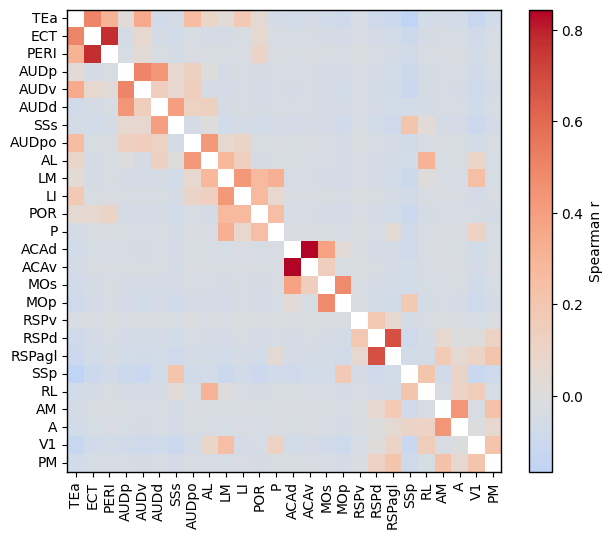

In [ ]:
reordered = mean_df.loc[column_names_ordered, column_names_ordered]
np.fill_diagonal(reordered.values, np.nan)
plt.figure(figsize=(7, 6)) 
g = sb.heatmap(
    data=fpf.convert_matrix_names(reordered), 
    cmap='Rbu', center=0,
    xticklabels=True, 
    yticklabels=True, 
    cbar_kws={'label': 'Spearman r'}
)
for _, spine in g.spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
cbar = g.collections[0].colorbar
cbar.outline.set_visible(True)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)

Now lets plot simulation of differences in labelling efficiency

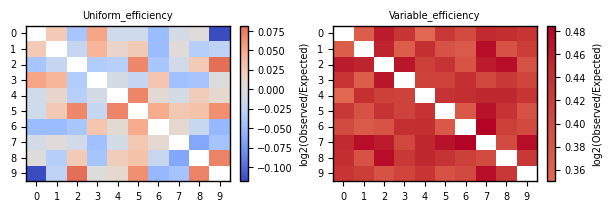

In [ ]:

n_areas = 10
proj_prob = np.ones(n_areas) * 0.2
titles= ['Uniform_efficiency', 'Variable_efficiency']
n_neurons = 100000
efficiency = np.random.rand(n_neurons)
constant_efficiency = np.ones(n_neurons) * 0.5
eff_dict = {}
fig, axs = plt.subplots(1, 2, figsize=(6, 2), constrained_layout=True)
for i, which_eff in enumerate([constant_efficiency, efficiency]):
    neurons_proj_prob = proj_prob[None, :] * which_eff[:, None]
    neurons_proj = np.random.rand(n_neurons, n_areas) < neurons_proj_prob #randomly simulate the detection of each neuron–area projection based on the projection probability and efficiency. take a random value between 0 and 1 for each area for each barcode. If the random value is less than the effiicency adjusted projection probability, we observe it as projecting there
    OR = pd.DataFrame(np.zeros((n_areas, n_areas)))
    for area_a in range(n_areas):
        for area_b in range(n_areas):
            if area_a == area_b:
                continue
            observed =(np.count_nonzero(neurons_proj[:, area_a] & neurons_proj[:, area_b]))/n_neurons
            expected = ((np.count_nonzero(neurons_proj[:, area_a]))/n_neurons)*((np.count_nonzero(neurons_proj[:, area_b]))/n_neurons)
            OR.iloc[area_a,area_b] = np.log2(observed/expected)
    eff_dict[titles[i]] = OR
    np.fill_diagonal(OR.values, np.nan)
    sb.heatmap(ax=axs[i], 
                data=OR, 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'log2(OR)'})
    axs[i].set_title(titles[i], size=7)
    axs[i].tick_params(axis='y', which='major', labelsize=7, rotation=0)
    axs[i].tick_params(axis='x', which='major', labelsize=7)

    for _, spine in axs[i].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

    cbar = axs[i].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)
    cbar.ax.tick_params(labelsize=7)
    cbar.set_label('log2(Observed/Expected)', fontsize=7)